# Plot Aggregate

Notebook to load experiment results and plot the following:
* Average contact map of the jet locations from the results
    * 1D tracks (optional)
* Histogram of the distribution of jet lengths in basepairs

In [1]:
import pandas as pd
import hicstraw
import bioframe as bf
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import cv2 as cv
from multiprocessing import Pool

import sys
sys.path.append('..')
from utils.plotting import plot_hic, plot_n_hic, genomic_labels

In [27]:
def get_pileups_dynamic_resolution(
    hic_file,
    bed_df_in,
    expected_stack_size,
    chrom_sizes,
    chromosomes='all',
    window_range=(None, None),
    data_type="observed",
    normalization="KR",
    sort=False,
    verbose=False
):
    """
    Generates Hi-C pileups for each region in bed_df_in, choosing for each
    region the resolution (from hic.getResolutions()) that makes
    (region_length / resolution) as close as possible to expected_stack_size.

    Parameters
    ----------
    hic_file : str
        Path to your Hi-C .hic file.
    bed_df_in : pandas.DataFrame
        Must contain columns ['chrom', 'start', 'end'].
    expected_stack_size : int
        Desired number of bins per side of your square pileup.
    chrom_sizes : pandas.DataFrame
        Columns ['chrom', 'length'] (or 'name','length' after trimming).
    chromosomes : 'all' | list of str | str
        Which chroms to include.
    window_range : tuple(int|None, int|None)
        (upstream, downstream) around the midpoint to override bed_df_in.
    data_type : str
        e.g. "observed", "oe", etc.
    normalization : str
        e.g. "KR", "VC", ...
    sort : bool
        If True, sorts bed_df naturally by chrom, start, end.

    Returns
    -------
    pileups : list of 2D np.ndarray
        Each is a square matrix of Hi-C contacts at the chosen resolution.
    bed_df_out : pandas.DataFrame
        The (possibly trimmed, sorted) DataFrame actually used.
    """

    # 1) Copy & optional sort
    bed_df = bed_df_in.copy()
    if sort:
        def chrom_key(c):
            m = re.search(r"(\d+)$", c)
            if m:
                return int(m.group(1))
            cl = c.lower()
            return {'x':23,'y':24,'m':25,'mt':25}.get(cl[-2:] if len(cl)>1 else cl[-1],100)
        bed_df['_ck'] = bed_df['chrom'].map(chrom_key)
        bed_df = bed_df.sort_values(['_ck','start','end']).drop(columns=['_ck']).reset_index(drop=True)

    # 2) apply window_range if given
    win_up, win_down = window_range
    if win_up is not None or win_down is not None:
        bed_df['mid'] = ((bed_df['start'] + bed_df['end'])//2)
        win_up = win_up or 0
        win_down = win_down or 0
        bed_df['start'] = bed_df['mid'] - win_up
        bed_df['end']   = bed_df['mid'] + win_down
        bed_df = bed_df.drop(columns=['mid'])
        # bioframe.trim wants a 'name' column on chrom_sizes
        chrom_sizes = chrom_sizes.copy()
        chrom_sizes['name'] = chrom_sizes['chrom'] + '-valid'
        bed_df[['start','end']] = bed_df[['start','end']].astype(int)
        bed_df = bf.trim(bed_df, chrom_sizes).dropna().reset_index(drop=True)
        bed_df[['start','end']] = bed_df[['start','end']].astype(int)

    # 3) restrict to desired chromosomes
    if chromosomes == 'all':
        chrom_set = bed_df['chrom'].unique().tolist()
    elif isinstance(chromosomes, str):
        chrom_set = [chromosomes]
    else:
        chrom_set = list(set(bed_df['chrom']).intersection(chromosomes))
    bed_df = bed_df[bed_df['chrom'].isin(chrom_set)].reset_index(drop=True)

    # 4) open hic & fetch available resolutions
    hic = hicstraw.HiCFile(hic_file)
    avail_res = sorted(hic.getResolutions())  # e.g. [500,1000,5000,...]

    # determine whether 'chr' prefix is used in the file
    names = [c.name for c in hic.getChromosomes()]
    no_chr_prefix = not any(n.startswith('chr') for n in names)

    # 5) build pileups
    pileups = []
    selected_resolutions = []
    for _, row in tqdm(bed_df.iterrows(), total=len(bed_df), desc="Retrieving pileups", disable=not verbose):
        chrom = row['chrom']
        key = chrom[3:] if no_chr_prefix and chrom.startswith('chr') else chrom

        # compute region length
        length = int(row['end']) - int(row['start'])

        # choose resolution that makes length/res ≈ expected_stack_size
        best_res = min(
            avail_res,
            key=lambda r: abs((length / r) - expected_stack_size)
        )

        selected_resolutions.append(best_res)

        # fetch matrix zoom data at that resolution
        mzd = hic.getMatrixZoomData(
            key, key,
            data_type, 
            normalization,
            'BP',
            best_res
        )

        # extract the pileup
        mat = mzd.getRecordsAsMatrix(
            int(row['start']), int(row['end']),
            int(row['start']), int(row['end'])
        )
        pileups.append(mat)

    return pileups, bed_df, selected_resolutions



def get_pileups(hic_file, bed_df_in, resolution, chrom_sizes,
                chromosomes='all', window_range=(None, None),
                data_type="observed", normalization="KR", sort=False):
    """
    Processes Hi-C data to generate pileups for genomic regions specified in a BED-format DataFrame

    Returns:
    --------
    pileups : list of numpy arrays
        Each array is a pileup matrix of Hi-C interaction data.
    bed_df  : pandas DataFrame
        Possibly sorted and trimmed bed DataFrame used for pileups.
    """
    bed_df = bed_df_in.copy()

    # Optional sort on natural chromosome order
    if sort:
        # Define a key function for numeric and special chromosomes
        def chrom_key(c):
            m = re.search(r"(\d+)$", c)
            if m:
                return int(m.group(1))
            cl = c.lower()
            if cl.endswith('x'):
                return 23
            if cl.endswith('y'):
                return 24
            if cl.endswith(('m', 'mt')):
                return 25
            return 100

        bed_df['sort_key'] = bed_df['chrom'].map(chrom_key)
        bed_df = bed_df.sort_values(['sort_key', 'start', 'end'])
        bed_df = bed_df.drop(columns=['sort_key']).reset_index(drop=True)

    # Handle custom window around midpoints
    win_up, win_down = window_range
    if win_up is not None or win_down is not None:
        bed_df['midpoint'] = ((bed_df['start'] + bed_df['end']) // 2)
        # default missing values
        win_up = win_up or 0
        win_down = win_down or 0
        bed_df['start'] = bed_df['midpoint'] - win_up
        bed_df['end'] = bed_df['midpoint'] + win_down
        bed_df = bed_df.drop(columns=['midpoint'])
        # Trim out-of-bounds
        # bioframe.trim expects a 'name' column on chrom_sizes
        chrom_sizes['name'] = chrom_sizes['chrom'] + '-valid'
        bed_df[['start', 'end']] = bed_df[['start', 'end']].astype(int)
        bed_df = bf.trim(bed_df, chrom_sizes)
        bed_df = bed_df.dropna().reset_index(drop=True)
        bed_df[['start', 'end']] = bed_df[['start', 'end']].astype(int)

    # Determine which chromosomes to include
    if chromosomes == 'all':
        chrom_set = list(bed_df['chrom'].unique())
    elif isinstance(chromosomes, (list, np.ndarray)):
        chrom_set = list(set(bed_df['chrom'].unique()) & set(chromosomes))
    elif isinstance(chromosomes, str):
        chrom_set = [chromosomes]
    else:
        print(f"Warning: 'chromosomes' argument improperly formatted: {chromosomes}")
        chrom_set = list(bed_df['chrom'].unique())

    # Filter bed_df by chrom_set in both branches
    bed_df = bed_df[bed_df['chrom'].isin(chrom_set)].reset_index(drop=True)

    # Open Hi-C file and detect prefix usage
    hic = hicstraw.HiCFile(hic_file)
    names = [c.name for c in hic.getChromosomes()]
    no_chr_prefix = not any(n.startswith('chr') for n in names)

    # Build pileups
    pileups = []
    if sort:
        for chrom in chrom_set:
            key = chrom[3:] if no_chr_prefix and chrom.startswith('chr') else chrom
            mzd = hic.getMatrixZoomData(key, key, data_type, normalization,
                                         'BP', int(resolution))
            sub = bed_df[bed_df['chrom'] == chrom]
            for _, row in tqdm(sub.iterrows(), total=len(sub)):
                mat = mzd.getRecordsAsMatrix(int(row['start']), int(row['end']),
                                             int(row['start']), int(row['end']))
                pileups.append(mat)
    else:
        for _, row in tqdm(bed_df.iterrows(), total=len(bed_df)):
            chrom = row['chrom']
            key = chrom[3:] if no_chr_prefix and chrom.startswith('chr') else chrom
            mzd = hic.getMatrixZoomData(key, key, data_type, normalization,
                                         'BP', int(resolution))
            mat = mzd.getRecordsAsMatrix(int(row['start']), int(row['end']),
                                         int(row['start']), int(row['end']))
            pileups.append(mat)

    return pileups, bed_df


def remove_stack_centromeres(stack, stack_positions, expected_stack_size):
    '''
    Essentially removes Hi-C windows in the stack that are not size `expected_stack_size`
    Returns modified stack, stack_positions
    '''
    # process centromeres
    stack_uniform = []
    problem = []
    for i, each in enumerate(stack):
        if each.shape[0] != expected_stack_size:
            problem.append(i)
        else:
            stack_uniform.append(each)

    stack = np.array(stack_uniform)
    stack_positions = stack_positions.drop(problem, axis=0).reset_index(drop=True)
    assert stack.shape[0] == len(stack_positions)
    return stack, stack_positions


def remove_and_resize_square_stacks(stack, stack_positions, expected_stack_size):
    """
    Filters out any arrays in `stack` that aren’t square, then
    resizes the remaining square arrays to (expected_stack_size, expected_stack_size).

    Parameters
    ----------
    stack : Sequence of 2D numpy arrays
        Each array should represent a Hi-C window.
    stack_positions : pandas.DataFrame
        Positions corresponding to each entry in `stack`.
    expected_stack_size : int
        The desired width and height for all retained windows.

    Returns
    -------
    (np.ndarray, pandas.DataFrame)
        - stack_resized: Array of shape (n_retained, expected_stack_size, expected_stack_size)
        - stack_positions_filtered: DataFrame of length n_retained
    """
    stack_uniform = []
    bad_indices = []

    for i, arr in enumerate(stack):
        # check it's 2D and square
        if arr.ndim != 2 or arr.shape[0] != arr.shape[1]:
            bad_indices.append(i)
            continue

        # resize square array to expected_stack_size × expected_stack_size
        resized = cv.resize(
            arr,
            (expected_stack_size, expected_stack_size),
            interpolation=cv.INTER_AREA
        )
        stack_uniform.append(resized)

    # build numpy array of resized windows
    stack_resized = np.array(stack_uniform)

    # drop bad rows from positions, reset index
    stack_positions_filtered = (
        stack_positions
        .drop(index=bad_indices, errors='ignore')
        .reset_index(drop=True)
    )

    # sanity check
    assert stack_resized.shape[0] == len(stack_positions_filtered), (
        f"Number of retained stacks ({stack_resized.shape[0]}) "
        f"does not match positions ({len(stack_positions_filtered)})"
    )

    return stack_resized, stack_positions_filtered


def assign_start_end(row):
    
    if row["x (bp)"].min() < row["y (bp)"].max():
        start = row["x (bp)"].min()
        end = row["y (bp)"].max()
    else:
        start = row["y (bp)"].min()
        end = row["x (bp)"].max()
    
    return pd.Series({"start": start, "end": end})


def generate_bed_df(df_summary, df_expanded, eps, fraction):
    """
    Generate a summary dataframe (bed file) that contains
    "chrom", "start", "end", in addition to all other columns in df_summary

    The "start" and "end" is computed to be the maximum extrusion point of the jet,
    where "maximum" is defined relative to the main diagonal

    The `eps` and `fraction` parameters controls the additional margin around the maximum extrusion point
    * `eps` is the fixed margin in basepairs
    * `fraction` is the fraction increase of the window size around the maximum extrusion point
    """
    # Need to make new columns for the window boundaries of aggregate plotting
    df_plot_summary = df_expanded.groupby('unique_id').apply(assign_start_end, include_groups=False).reset_index()

    assert np.all(df_plot_summary['end'] >= df_plot_summary['start'])

    # Epsilon margin around the maximum extrusion point
    curr_window_size = df_plot_summary['end'] - df_plot_summary['start']
    df_plot_summary['start'] -= curr_window_size * fraction + eps
    df_plot_summary['end'] += curr_window_size * fraction + eps
    
    # just keep the essentials for merging 
    df_plot_summary = df_plot_summary[['unique_id','start','end']]

    df_summary_copy = df_summary.copy()

    # Drop start and end columns of the old summary dataframe (this is generated from the miajet program)
    df_summary_copy = df_summary_copy.drop(columns=['start', 'end'])

    # Join on "unique_id" with df_plot_summary
    df_summary_copy = df_summary_copy.merge(df_plot_summary, on='unique_id', how='inner')

    return df_summary_copy


def worker(args):
    """
    Worker function to run one iteration of your loop.
    Expects a tuple: (hic_file, bed_df, expected_stack_size, chrom_sizes, data_type, normalization)
    Returns: (mean_map, stack_s, stack_d, resolution)
    """
    hic_file, bed_df, expected_stack_size, chrom_sizes, data_type, normalization = args

    # 1) get pileups
    s, d, r = get_pileups_dynamic_resolution(
        hic_file,
        bed_df_in=bed_df,
        expected_stack_size=expected_stack_size,
        chrom_sizes=chrom_sizes,
        chromosomes='all',
        window_range=(None, None),
        data_type=data_type,
        normalization=normalization,
        sort=False
    )

    # 2) post-process
    s, d = remove_and_resize_square_stacks(s, d, expected_stack_size=expected_stack_size)
    # s = np.log10(s + 1)  # if you still want the log transform

    # 3) compute aggregate map
    mean_map = np.mean(s, axis=0)

    return mean_map, s, d, r

In [ ]:
# ——————————————————————————————————————————————
# one cell: loop over 4 experiments, make two plots each
# ——————————————————————————————————————————————

# list out your 4 experiments
experiments = [
    {
        "hic_file": "/nfs/turbo/umms-minjilab/downloaded_data/splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9.hic",
        "experiment_name": "splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9_chr_combined",
        "genome": "mm9",
    },
    {
        "hic_file": "/nfs/turbo/umms-minjilab/downloaded_data/Repli-HiC_K562_WT_totalS.hic",
        "experiment_name": "Repli-HiC_K562_WT_totalS_chr_combined",
        "genome": "hg19",
    },
    {
        "hic_file": "/nfs/turbo/umms-minjilab/downloaded_data/GSE199059_CD69negDPWTR1R2R3R4_merged.hic",
        "experiment_name": "GSE199059_CD69negDPWTR1R2R3R4_merged_chr_combined",
        "genome": "mm9",
    },
    {
        "hic_file": "/nfs/turbo/umms-minjilab/downloaded_data/DP-thymocytes_WT_hic_Guo-2022_GSE199059_mm10-remapped.hic",
        "experiment_name": "DP-thymocytes_WT_hic_Guo-2022_GSE199059_mm10-remapped_chr_combined",
        "genome": "mm10",
    },
]

# your parameters (already defined elsewhere in the notebook you can omit if you like)
result_type        = ["saliency-90-p-0.1", "saliency-90-p-0.05", "saliency-90-p-0.01", "saliency-90", "p-0.1", "p-0.05", "p-0.01"]
data_type          = "oe"
normalization      = "KR"
expected_stack_size= 100
num_cores          = 8

for exp in experiments:
    hic_file        = exp["hic_file"]
    experiment_name = exp["experiment_name"]
    genome          = exp["genome"]
    save_folder     = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/{experiment_name}_50Kb"

    # build paths to your CSVs
    f_expanded_table = [f"{save_folder}/{experiment_name}_{rt}_50Kb_expanded_table.csv" for rt in result_type]
    f_summary_table  = [f"{save_folder}/{experiment_name}_{rt}_50Kb_summary_table.csv"  for rt in result_type]

    # load
    df_expanded = [pd.read_csv(f, index_col=False, comment="#") for f in f_expanded_table]
    df_summary  = [pd.read_csv(f, index_col=False, comment="#") for f in f_summary_table]

    # turn summary+expanded into a bed‐df
    for i in range(len(result_type)):
        df_summary[i] = generate_bed_df(df_summary[i], df_expanded[i], eps=0, fraction=0.5)

    # fetch chrom sizes
    chrom_sizes = bf.fetch_chromsizes(genome, as_bed=True)

    # construct the pileup and aggregate map using multiprocess
    jobs = [
        (hic_file,
            df_summary[i],
            expected_stack_size,
            chrom_sizes,
            data_type,
            normalization)
        for i in range(len(result_type))
    ]

    # containers for results
    agg_map   = []
    stack     = []
    df_stack  = []
    resolutions = []

    with Pool(processes=num_cores) as pool:
        # imap yields results as they complete; tqdm tracks progress
        for mean_map, s, d, r in tqdm(pool.imap(worker, jobs),
                                        total=len(jobs),
                                        desc="Processing piles"):
            agg_map.append(mean_map)
            stack.append(s)
            df_stack.append(d)
            resolutions.append(r)

    # —————————————————————————————————————————————————————
    # 1) your “full” multi‐threshold plot
    # —————————————————————————————————————————————————————
    plot_n_hic(
        agg_map,
        suptitle=f"{experiment_name} {data_type} {normalization}",
        resolution=None,
        cmap_label=None,
        titles=result_type,
        cmap='Reds',
        show=False, 
        ppr=4,
        savepath=f"{save_folder}/{experiment_name}_agg_map-{data_type}-{normalization}.png"
    )

    # —————————————————————————————————————————————————————
    # 2) diagnostic: top 36 jets for rt = 'saliency-90-p-0.1'  (idx = 0)
    # —————————————————————————————————————————————————————
    idx   = 0
    top_n = 36
    rt = result_type[idx]

    # pick the top‐36 rows by jet_saliency
    top_idx       = df_stack[idx].nlargest(top_n, "jet_saliency").index
    sampled_df    = df_stack[idx].loc[top_idx].reset_index(drop=True)
    sampled_stack = stack[idx][top_idx]

    # build titles & shifts exactly as before
    titles = (
        sampled_df["chrom"].astype(str) + ":" +
        sampled_df["end"].apply(lambda x: genomic_labels(x, N=1))
    )
    titles += " (saliency: " + sampled_df["jet_saliency"].astype(str) + ")"
    titles += "\nResolution: " + pd.Series(
        [genomic_labels(r, N=1) for r in sampled_df["length"]]
    ).astype(str)
    titles = titles.tolist()
    genomic_shift = sampled_df["start"].to_numpy()

    # compute per‐panel vmax if you like:
    vmaxes = [np.percentile(mat, 99) for mat in sampled_stack]

    plot_n_hic(
        sampled_stack,
        titles=titles,
        resolution=resolutions[idx],
        suptitle=f"{experiment_name}\nTop {top_n} Jets for {result_type[idx]}",
        show=False,
        genomic_shift=genomic_shift,
        cmap_label=None,
        vmax=vmaxes,
        ppr=6,
        cmap="Reds",
        savepath=f"{save_folder}/{experiment_name}_{rt}_diagnostic-top-{top_n}-{data_type}-{normalization}.png"
    )


Processing piles:  14%|█▍        | 1/7 [00:04<00:27,  4.59s/it]

In [17]:
# Let the notebook know what result you want to aggregate and analyze
# Specify the "*_expanded_table.csv" file (either a single chromosome, or whole genome after running `combine_results.ipynb`)

hic_file = "/nfs/turbo/umms-minjilab/downloaded_data/splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9.hic"
experiment_name = "splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9_chr_combined"
save_folder = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/{experiment_name}_50Kb"
result_type = ["saliency-90-p-0.1", "saliency-90-p-0.05", "saliency-90-p-0.01", "saliency-90", "p-0.1", "p-0.05", "p-0.01"]
f_expanded_table = []
f_summary_table = []
for rt in result_type:
    f_expanded_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_expanded_table.csv")
    f_summary_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_summary_table.csv")
genome = "mm9"

# hic_file = "/nfs/turbo/umms-minjilab/downloaded_data/Repli-HiC_K562_WT_totalS.hic"
# experiment_name = "Repli-HiC_K562_WT_totalS_chr_combined"
# save_folder = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/{experiment_name}_50Kb"
# result_type = ["saliency-90-p-0.1", "saliency-90-p-0.05", "saliency-90-p-0.01", "saliency-90", "p-0.1", "p-0.05", "p-0.01"]
# f_expanded_table = []
# f_summary_table = []
# for rt in result_type:
#     f_expanded_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_expanded_table.csv")
#     f_summary_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_summary_table.csv")
# genome = "hg19"

# hic_file = "/nfs/turbo/umms-minjilab/downloaded_data/GSE199059_CD69negDPWTR1R2R3R4_merged.hic"
# experiment_name = "GSE199059_CD69negDPWTR1R2R3R4_merged_chr_combined"
# save_folder = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/{experiment_name}_50Kb"
# result_type = ["saliency-90-p-0.1", "saliency-90-p-0.05", "saliency-90-p-0.01", "saliency-90", "p-0.1", "p-0.05", "p-0.01"]
# f_expanded_table = []
# f_summary_table = []
# for rt in result_type:
#     f_expanded_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_expanded_table.csv")
#     f_summary_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_summary_table.csv")
# genome = "mm9"

# hic_file = "/nfs/turbo/umms-minjilab/downloaded_data/DP-thymocytes_WT_hic_Guo-2022_GSE199059_mm10-remapped.hic"
# experiment_name = "DP-thymocytes_WT_hic_Guo-2022_GSE199059_mm10-remapped_chr_combined"
# save_folder = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/{experiment_name}_50Kb"
# result_type = ["saliency-90-p-0.1", "saliency-90-p-0.05", "saliency-90-p-0.01", "saliency-90", "p-0.1", "p-0.05", "p-0.01"]
# f_expanded_table = []
# f_summary_table = []
# for rt in result_type:
#     f_expanded_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_expanded_table.csv")
#     f_summary_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_summary_table.csv")
# genome = "mm10"

# Note that these parmameters need not be the same as the parameters used to call the jets
# This resolution is used for plotting purposes 
# resolution = 50000  
data_type = "oe"
normalization = "KR"
# window_size = 6e6
# expected_stack_size = np.ceil(window_size / resolution + 1).astype(int)
expected_stack_size = 100

In [18]:
# Load in tables
df_expanded = []
df_summary = []

for i in range(len(result_type)):
    df_expanded.append(pd.read_csv(f_expanded_table[i], index_col=False, comment="#"))
    df_summary.append(pd.read_csv(f_summary_table[i], index_col=False, comment="#"))

# Fetch chromosome sizes for this genome
chrom_sizes = bf.fetch_chromsizes(genome, as_bed=True)

In [28]:
for i in range(len(result_type)):
    df_summary[i] = generate_bed_df(df_summary[i], df_expanded[i], eps=500e3, fraction=0.5)

In [29]:
# stack, df_stack = get_pileups(hic_file, 
#                               bed_df_in=df_summary, 
#                               resolution=int(50e3), 
#                               chrom_sizes=chrom_sizes,
#                               chromosomes='all',
#                               window_range=(window_size // 2, window_size // 2),
#                               data_type=data_type, 
#                               normalization=normalization)


# Processing stack
# stack, df_stack = remove_stack_centromeres(stack, df_stack, expected_stack_size=expected_stack_size)


# Single core
# agg_map = []
# stack = []
# df_stack = []
# resolutions = []

# for i in range(len(result_type)):
#     s, d, r = get_pileups_dynamic_resolution(
#         hic_file,
#         bed_df_in=df_summary[i],
#         expected_stack_size=expected_stack_size,
#         chrom_sizes=chrom_sizes,
#         chromosomes='all',
#         window_range=(None, None),
#         data_type=data_type,
#         normalization=normalization,
#         sort=False
#     )

#     # do processing on stack now
#     s, d = remove_and_resize_square_stacks(s, d, expected_stack_size=expected_stack_size)
#     # s = np.log10(s + 1) # log transform for visualization

#     agg_map.append(np.mean(s, axis=0))  # Aggregate map for this result type

#     stack.append(s)
#     df_stack.append(d)
#     resolutions.append(r)


# Multi-core
num_cores = 8

# build the list of arguments for each job
jobs = [
    (hic_file,
        df_summary[i],
        expected_stack_size,
        chrom_sizes,
        data_type,
        normalization)
    for i in range(len(result_type))
]

# containers for results
agg_map   = []
stack     = []
df_stack  = []
resolutions = []

with Pool(processes=num_cores) as pool:
    # imap yields results as they complete; tqdm tracks progress
    for mean_map, s, d, r in tqdm(pool.imap(worker, jobs),
                                    total=len(jobs),
                                    desc="Processing piles"):
        agg_map.append(mean_map)
        stack.append(s)
        df_stack.append(d)
        resolutions.append(r)


Processing piles: 100%|██████████| 7/7 [01:35<00:00, 13.68s/it]


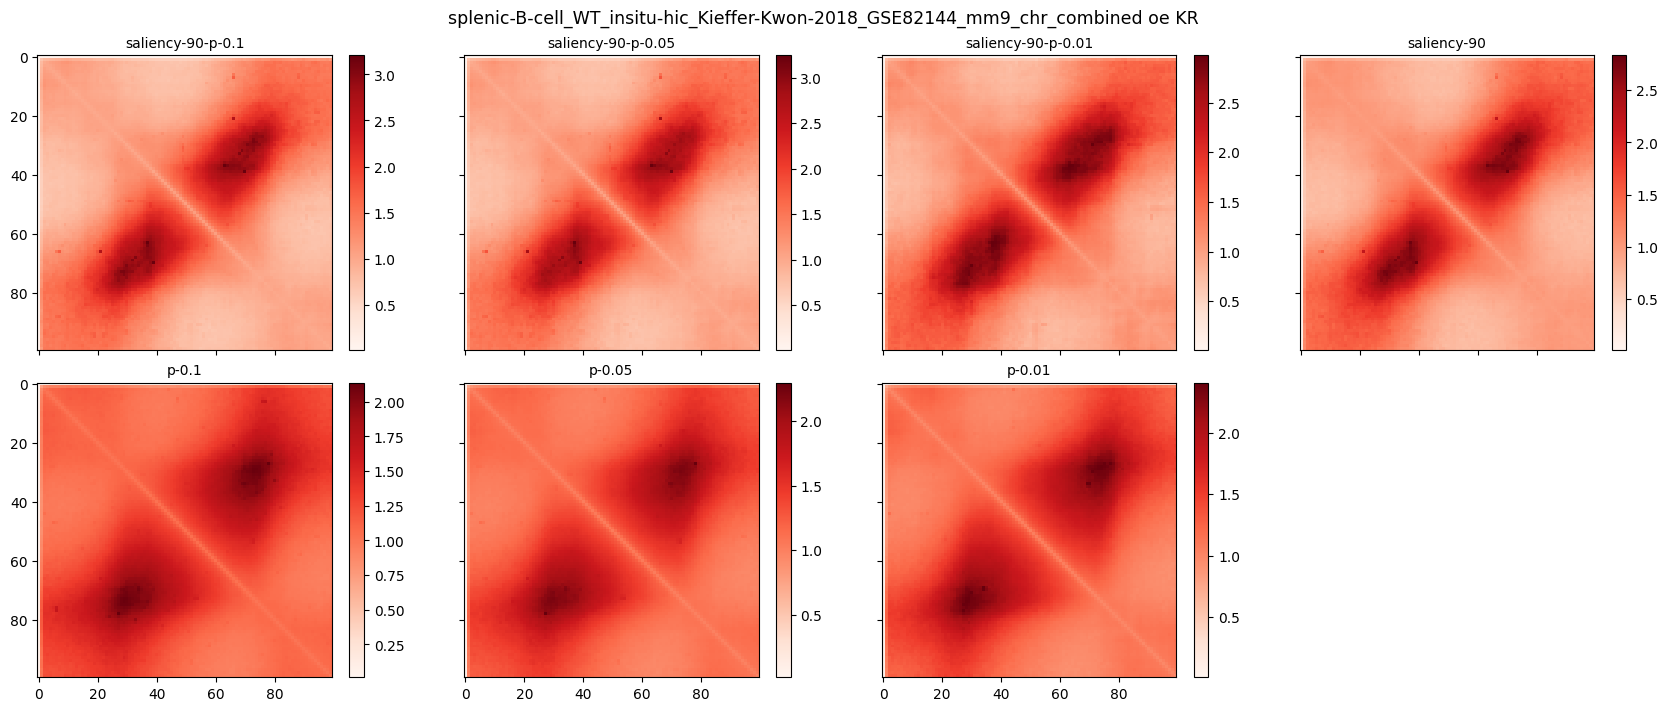

In [21]:
plot_n_hic(
    agg_map,
    suptitle=f"{experiment_name} {data_type} {normalization}",
    resolution=None,
    cmap_label=None,
    titles=result_type,
    cmap='Reds',
    show=True, 
    ppr=4,
    savepath=f"{save_folder}/{experiment_name}_agg_map-{data_type}-{normalization}.png"
)

In [30]:
idx = 0
rt = result_type[idx]
rt

'saliency-90-p-0.1'

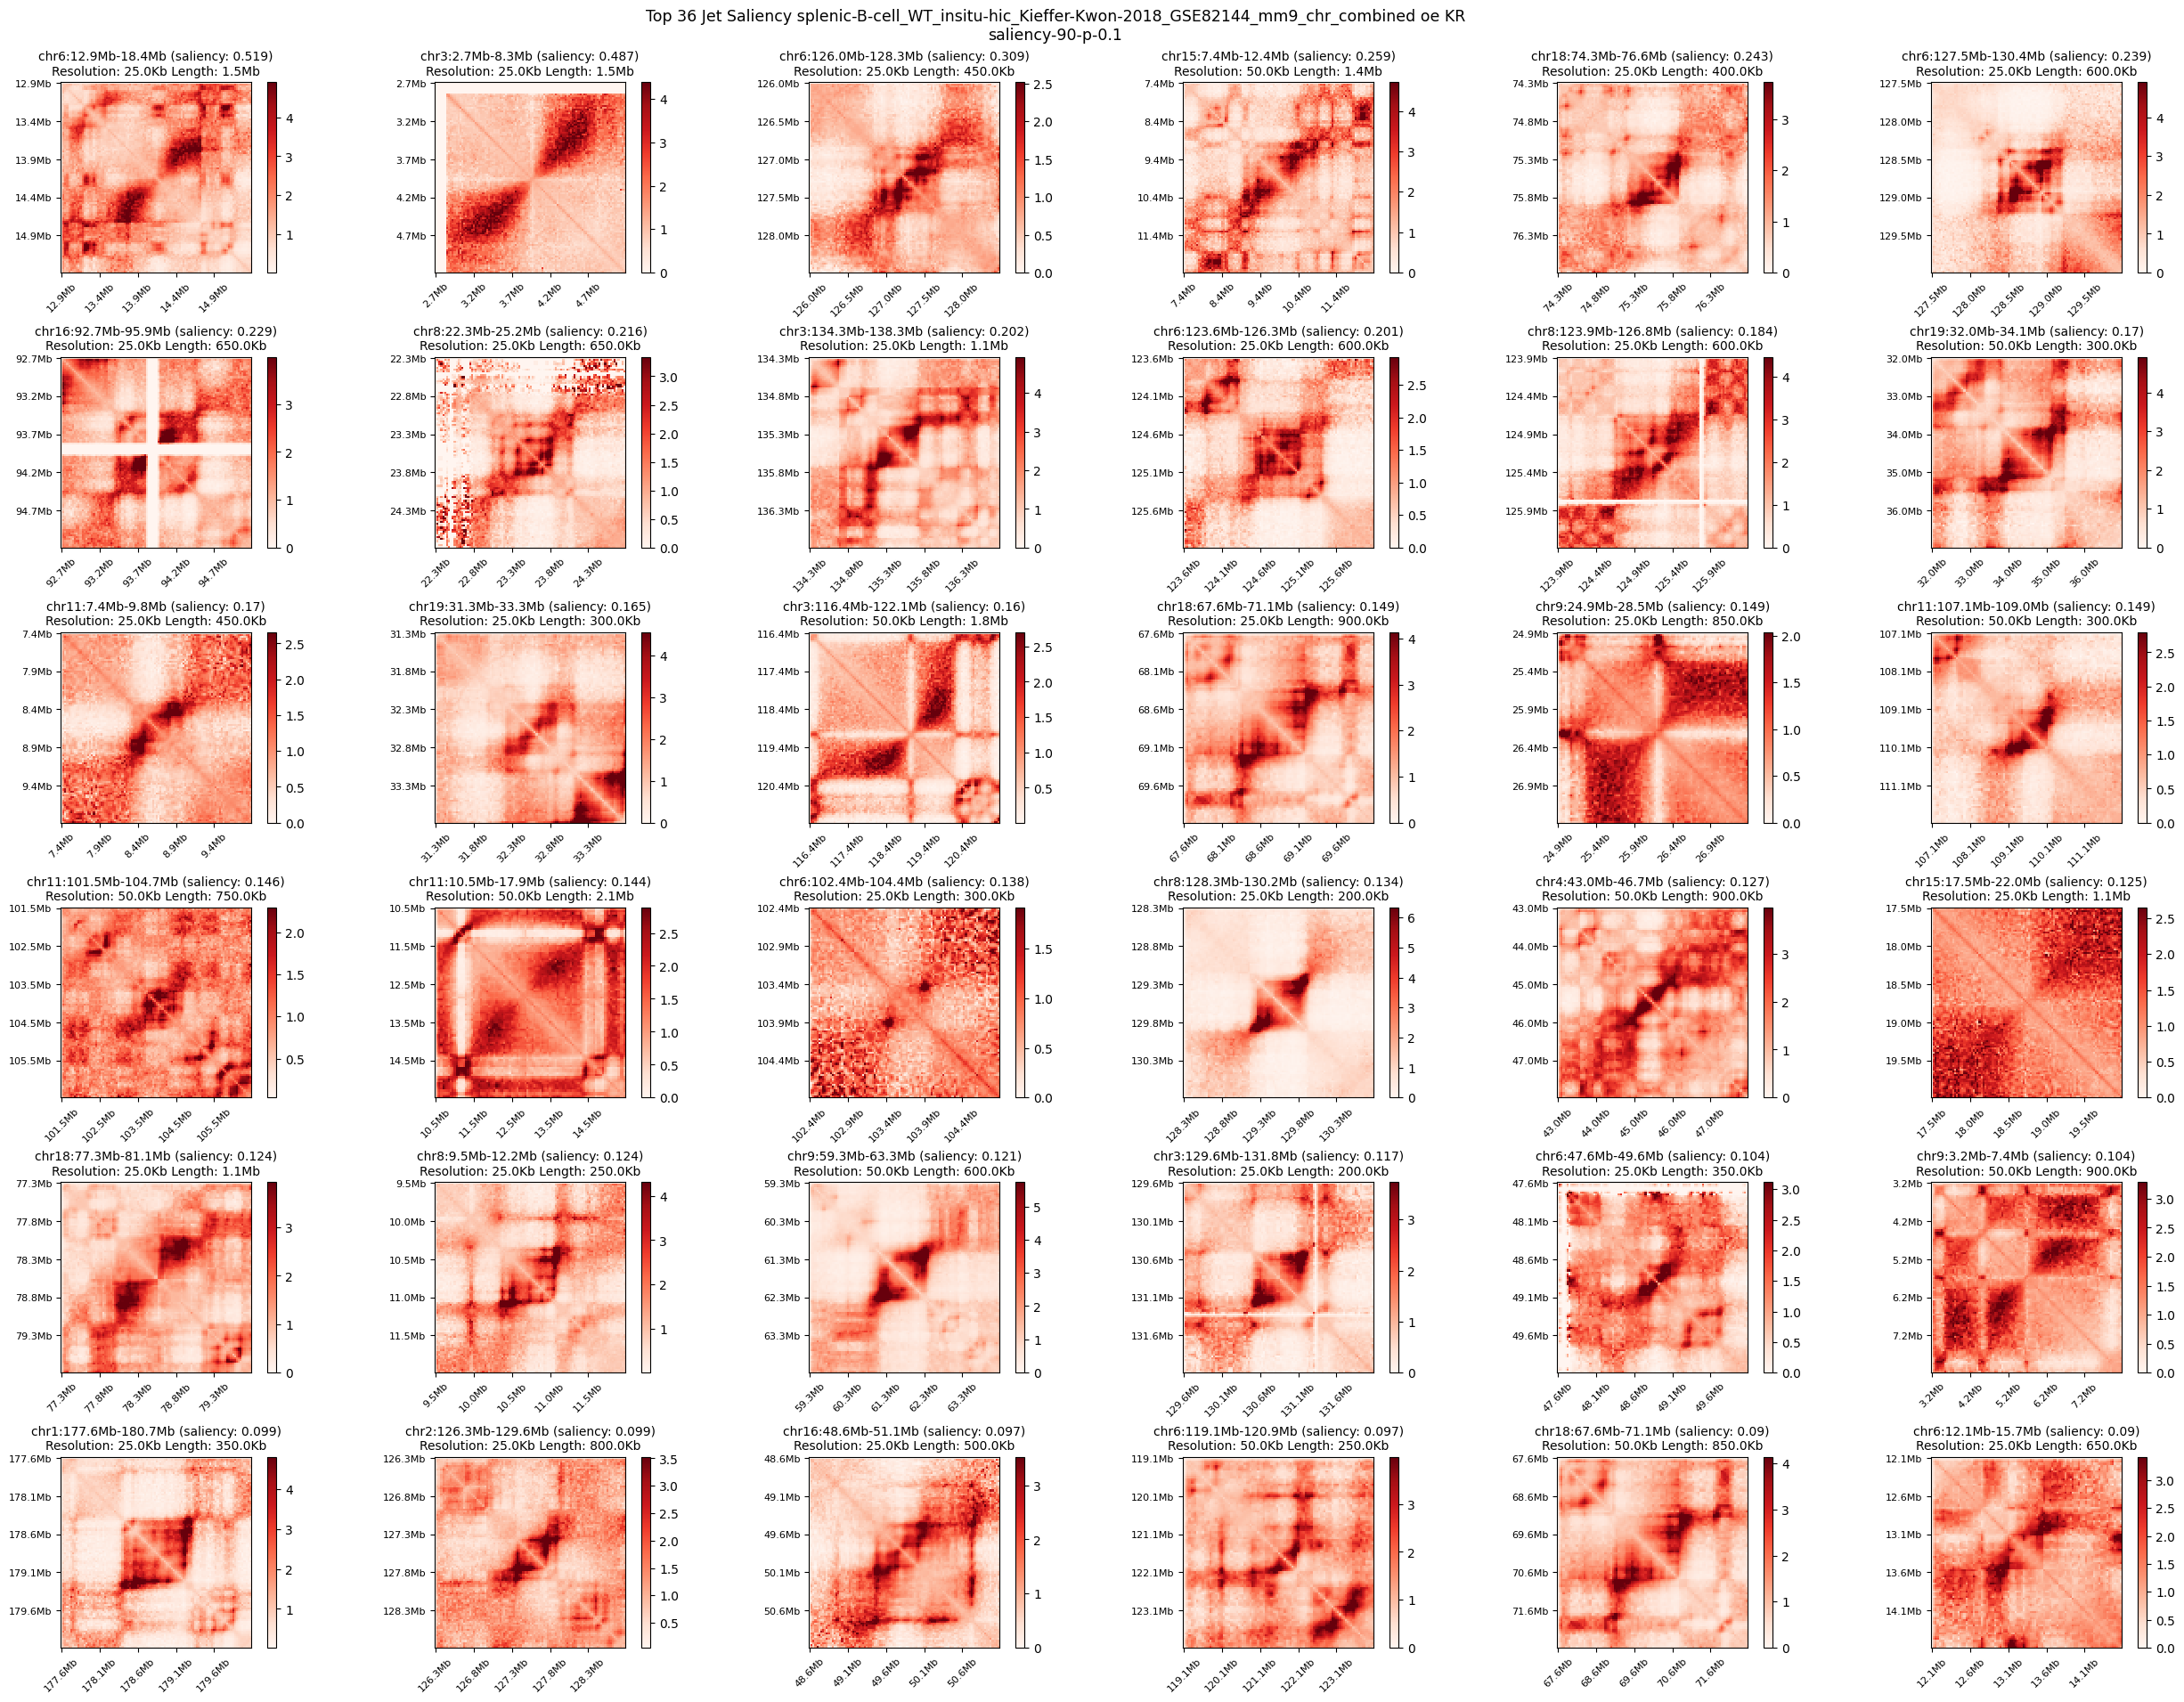

In [31]:
# Select top jets according to "jet_saliency" column
top_n = 36
# 1) get the original row‐indices of the top N
top_idx = df_stack[idx].nlargest(top_n, "jet_saliency").index

# 2) subset the DataFrame (and only then reset if you like)
sampled_df_stack = df_stack[idx].loc[top_idx].reset_index(drop=True)

# 3) subset the array with those SAME indices
sampled_stack = stack[idx][top_idx]

titles = sampled_df_stack["chrom"].astype(str) + ":" + sampled_df_stack["start"].apply(lambda x : genomic_labels(x, N=1)) + "-" + sampled_df_stack["end"].apply(lambda x : genomic_labels(x, N=1))
titles += " (saliency: " + sampled_df_stack["jet_saliency"].astype(str) + ")"
titles += f"\nResolution: " + pd.Series([genomic_labels(r, N=1) for r in resolutions[idx]]).astype(str) + " Length: " + sampled_df_stack["length"].apply(lambda x : genomic_labels(x, N=1)).astype(str)
titles = titles.tolist()

genomic_shift = sampled_df_stack["start"].to_numpy()

vmaxes = [np.percentile(s, 99) for s in sampled_stack]

plot_n_hic(sampled_stack, 
           titles=titles, 
           resolution=resolutions[idx],
           suptitle=f"Top {top_n} Jet Saliency {experiment_name} {data_type} {normalization}\n{rt}", 
           show=True, 
           genomic_shift=genomic_shift, 
           cmap_label=None, 
           vmax=vmaxes,
           ppr=6,
           cmap="Reds")

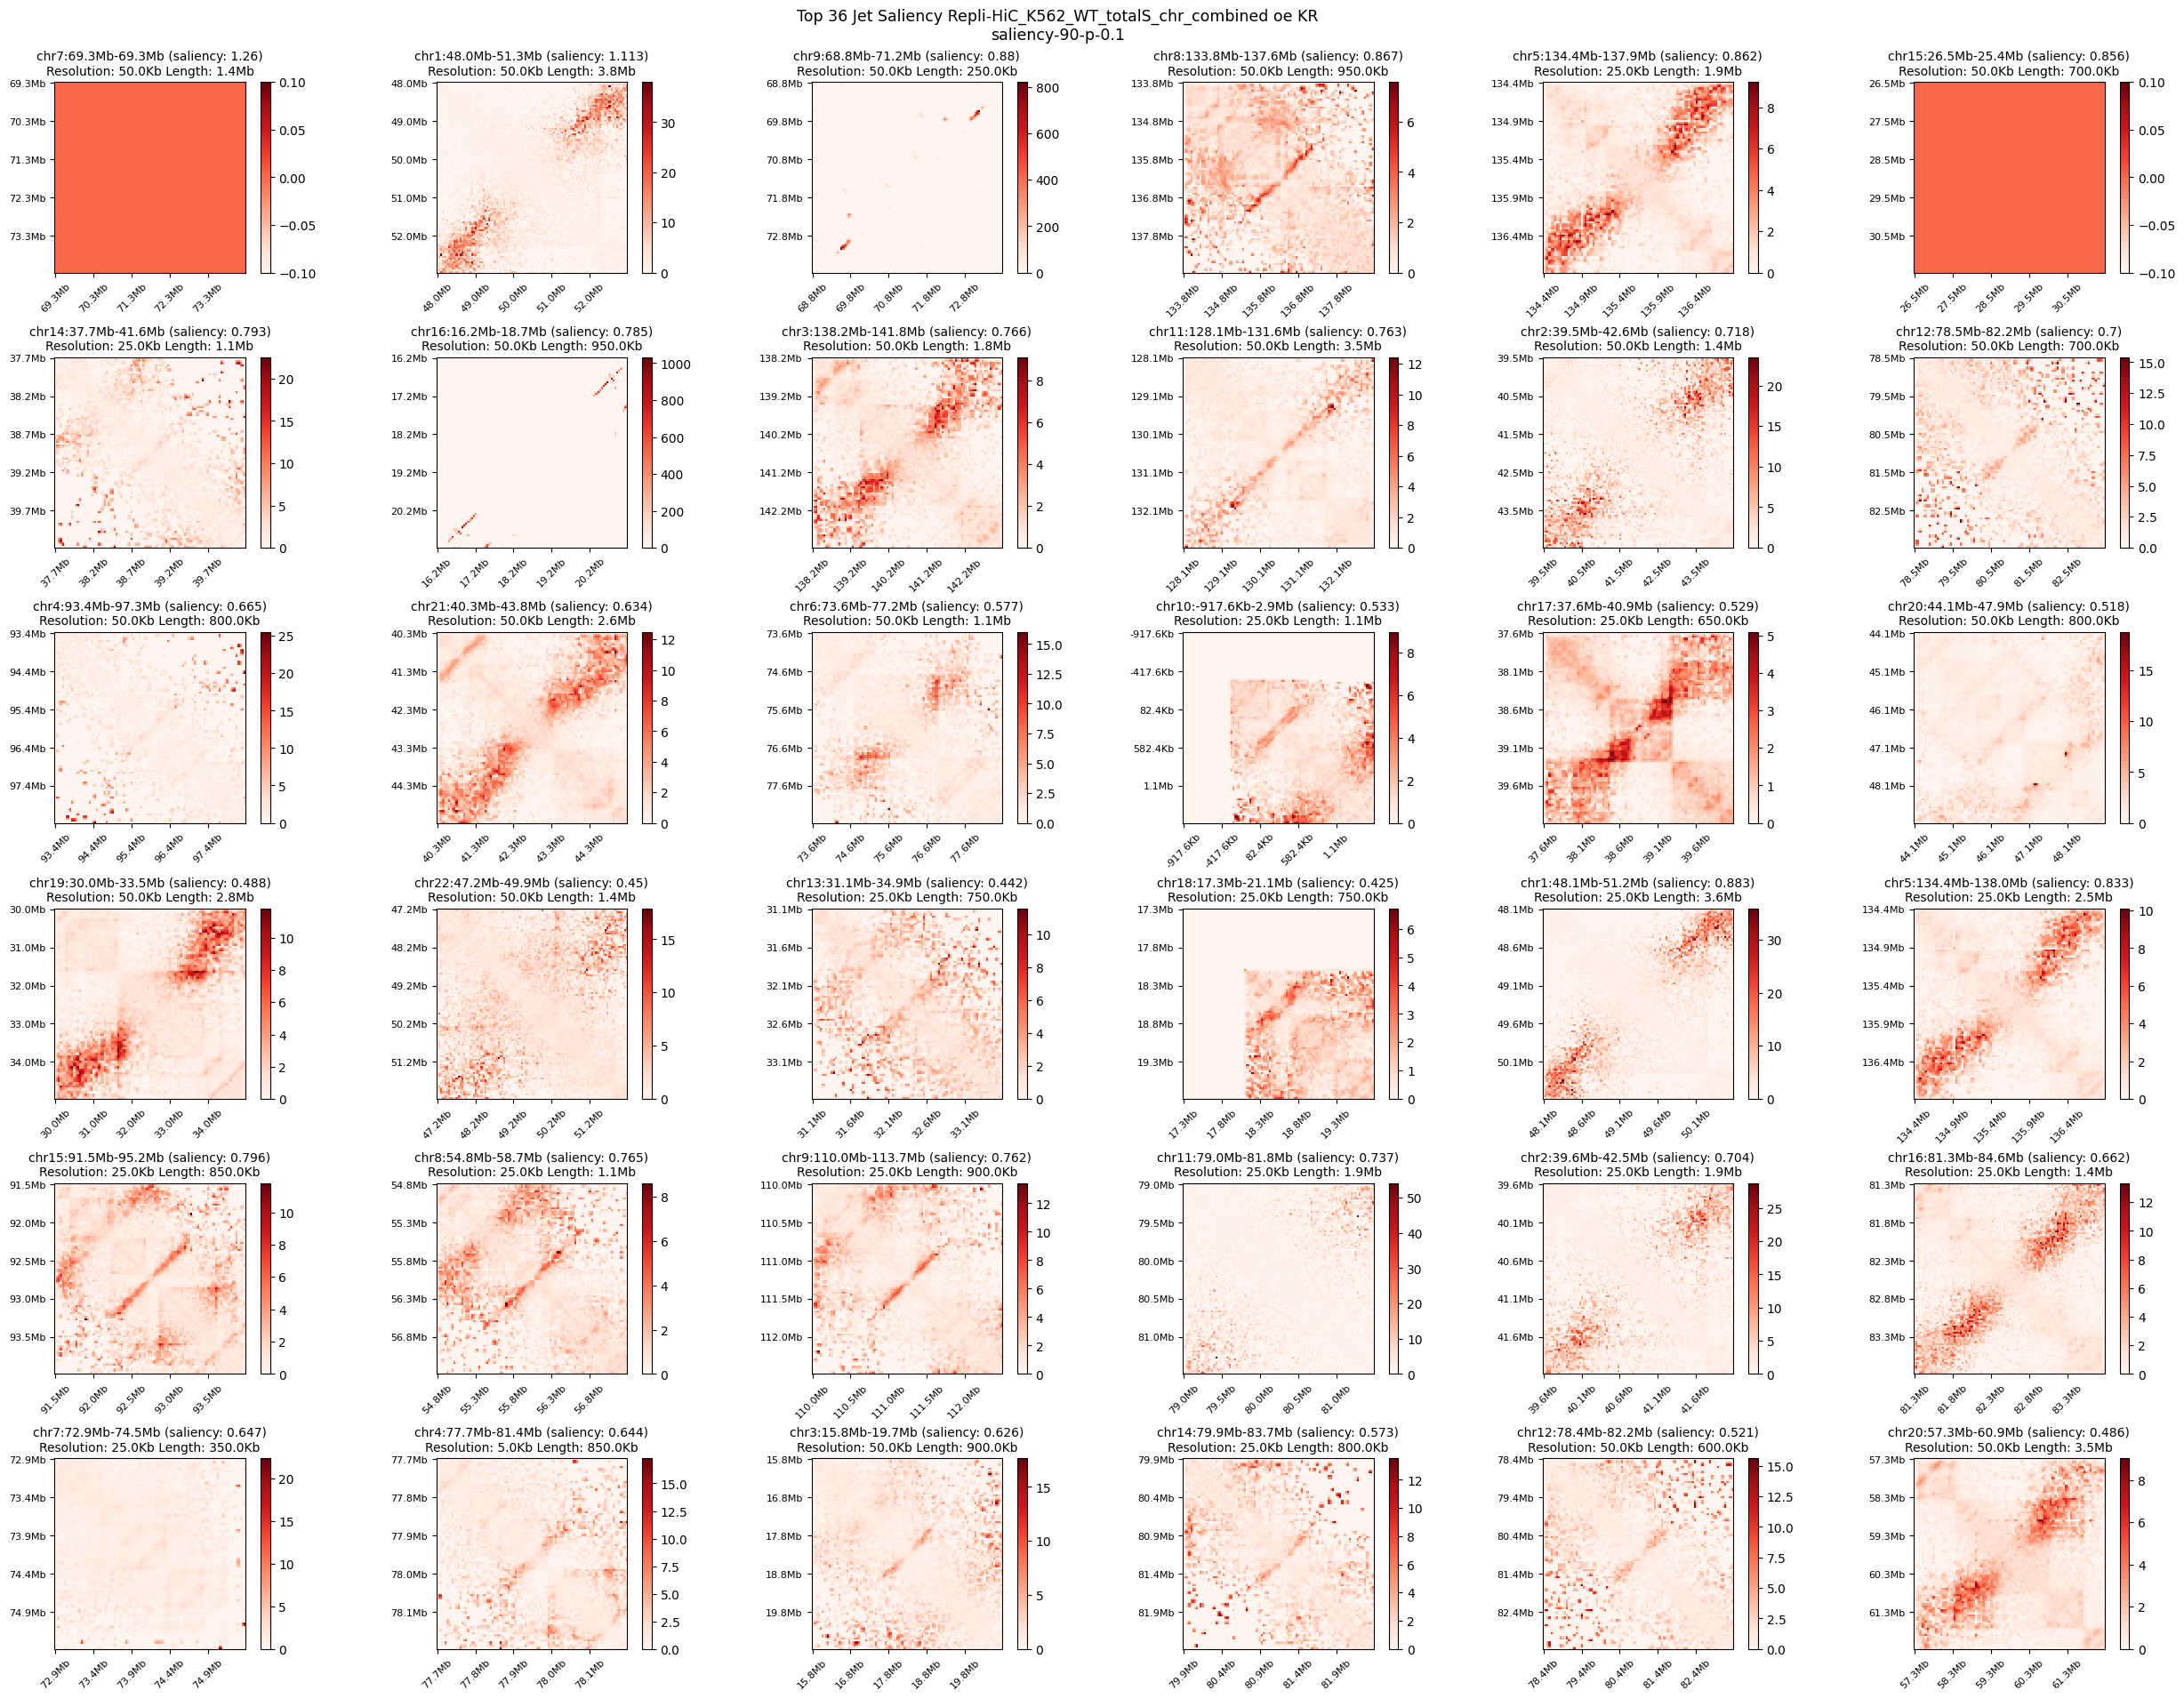

In [ ]:
top_n = 36

# 1) compute per‐chromosome rank (1 = highest jet_saliency in each chrom)
df = df_stack[idx].copy()
df['chrom_rank'] = (
    df
    .groupby('chrom')['jet_saliency']
    .rank(method='dense', ascending=False)   # descending → rank1 highest saliency
    .astype(int)
)

# 2) sort by (rank, then saliency) and pick top_n
sorted_df = (
    df
    .sort_values(['chrom_rank', 'jet_saliency'], ascending=[True, False])
    .head(top_n)
)
top_idx = sorted_df.index

# 3) subset both DataFrame and array by those indices
sampled_df_stack = df_stack[idx].loc[top_idx].reset_index(drop=True)
sampled_stack     = stack[idx][top_idx]

# rebuild your titles and shifts exactly as before
titles = (
    sampled_df_stack["chrom"].astype(str) + ":"
    + sampled_df_stack["start"].apply(lambda x: genomic_labels(x, N=1)) + "-"
    + sampled_df_stack["end"].apply(lambda x: genomic_labels(x, N=1))
    + " (saliency: " + sampled_df_stack["jet_saliency"].astype(str) + ")"
)
titles += (
    "\nResolution: " 
    + pd.Series([genomic_labels(r, N=1) for r in resolutions[idx]]).astype(str)
    + " Length: " 
    + sampled_df_stack["length"].apply(lambda x: genomic_labels(x, N=1)).astype(str)
)
titles = titles.tolist()

genomic_shift = sampled_df_stack["start"].to_numpy()

plot_n_hic(
    sampled_stack, 
    titles=titles, 
    resolution=resolutions[idx],
    suptitle=(
        f"Top {top_n} Jet Saliency {experiment_name} "
        f"{data_type} {normalization}\n{rt}"
    ), 
    show=True, 
    genomic_shift=genomic_shift, 
    cmap_label=None, 
    ppr=6,
    cmap="Reds"
)


In [ ]:
df_stack[0].loc[df_stack[0]["chrom"] == "chr7"].sort_values("jet_saliency", ascending=False)

unique_id chrom   length  input_mean  angle_mean  width_mean  \
960      chr7_12_3  chr7  1400000       0.342      89.810       3.206   
961   chr7_15399_0  chr7   350000       0.636      86.450       1.093   
962    chr7_725_12  chr7  1050000       0.335      87.371       8.570   
963      chr7_18_7  chr7  1250000       0.343      89.926       2.692   
964      chr7_22_9  chr7  1450000       0.290     104.047       5.485   
...            ...   ...      ...         ...         ...         ...   
1052     chr7_44_3  chr7   300000       0.559      93.239       2.700   
1053   chr7_9561_2  chr7   400000       0.210      86.493       2.329   
1054    chr7_37_14  chr7  2100000       0.162      63.593       8.718   
1055  chr7_19789_0  chr7   300000       0.089      90.396       0.361   
1056    chr7_347_9  chr7  1000000       0.102      90.963       5.379   

      jet_saliency     ks  p-val_raw  p-val_corr         start           end  
960          1.260  0.821      0.000       0.000  6.932259e+07  6.934627e+07  
961          0.647  1.000      0.000       0.002  7.288970e+07  7.448108e+07  
962          0.598  0.810      0.000       0.000  2.114415e+06  5.385558e+06  
963          0.559  0.640      0.000       0.000  3.103095e+07  3.478894e+07  
964          0.384  0.724      0.000       0.000  8.740867e+07  9.032903e+07  
...            ...    ...        ...         ...           ...           ...  
1052         0.091  1.000      0.001       0.005  9.327687e+07  9.710583e+07  
1053         0.090  1.000      0.000       0.001  6.856128e+07  7.162187e+07  
1054         0.090  0.690      0.000       0.000  1.763921e+07  2.034509e+07  
1055         0.087  0.667      0.071       0.081  8.629745e+07  8.816624e+07  
1056         0.085  0.850      0.000       0.000  1.537060e+08  1.543302e+08  

[97 rows x 12 columns]

In [ ]:
stack[0][960]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.45178127, 1.45178127,
        1.45178127],
       [0.        , 0.        , 0.        , ..., 1.45178127, 1.45178127,
        1.45178127],
       [0.        , 0.        , 0.        , ..., 1.45178127, 1.45178127,
        1.45178127]])

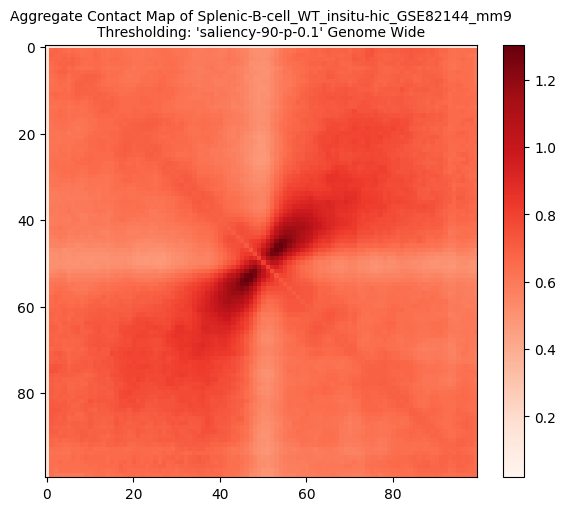

In [ ]:
plot_hic(agg_map, 
         resolution=None, # variable resolution 
         cmap="Reds",
         title="Aggregate Contact Map of Splenic-B-cell_WT_insitu-hic_GSE82144_mm9\nThresholding: 'saliency-90-p-0.1' Genome Wide")

In [ ]:
# Select top jets according to "jet_saliency" column
top_n = 36
# 1) get the original row‐indices of the top N
top_idx = df_stack.nlargest(top_n, "jet_saliency").index

# 2) subset the DataFrame (and only then reset if you like)
sampled_df_stack = df_stack.loc[top_idx].reset_index(drop=True)

# 3) subset the array with those SAME indices
sampled_stack = stack[top_idx]


titles = sampled_df_stack["chrom"].astype(str) + ":" + sampled_df_stack["start"].apply(lambda x : genomic_labels(x, N=1)) + "-" + sampled_df_stack["end"].apply(lambda x : genomic_labels(x, N=1))
titles += " (saliency: " + sampled_df_stack["jet_saliency"].astype(str) + ")"
titles += f"\nResolution: " + pd.Series([genomic_labels(r, N=1) for r in resolutions]).astype(str) + " Length: " + sampled_df_stack["length"].apply(lambda x : genomic_labels(x, N=1)).astype(str)
titles = titles.tolist()

genomic_shift = sampled_df_stack["start"].to_numpy()

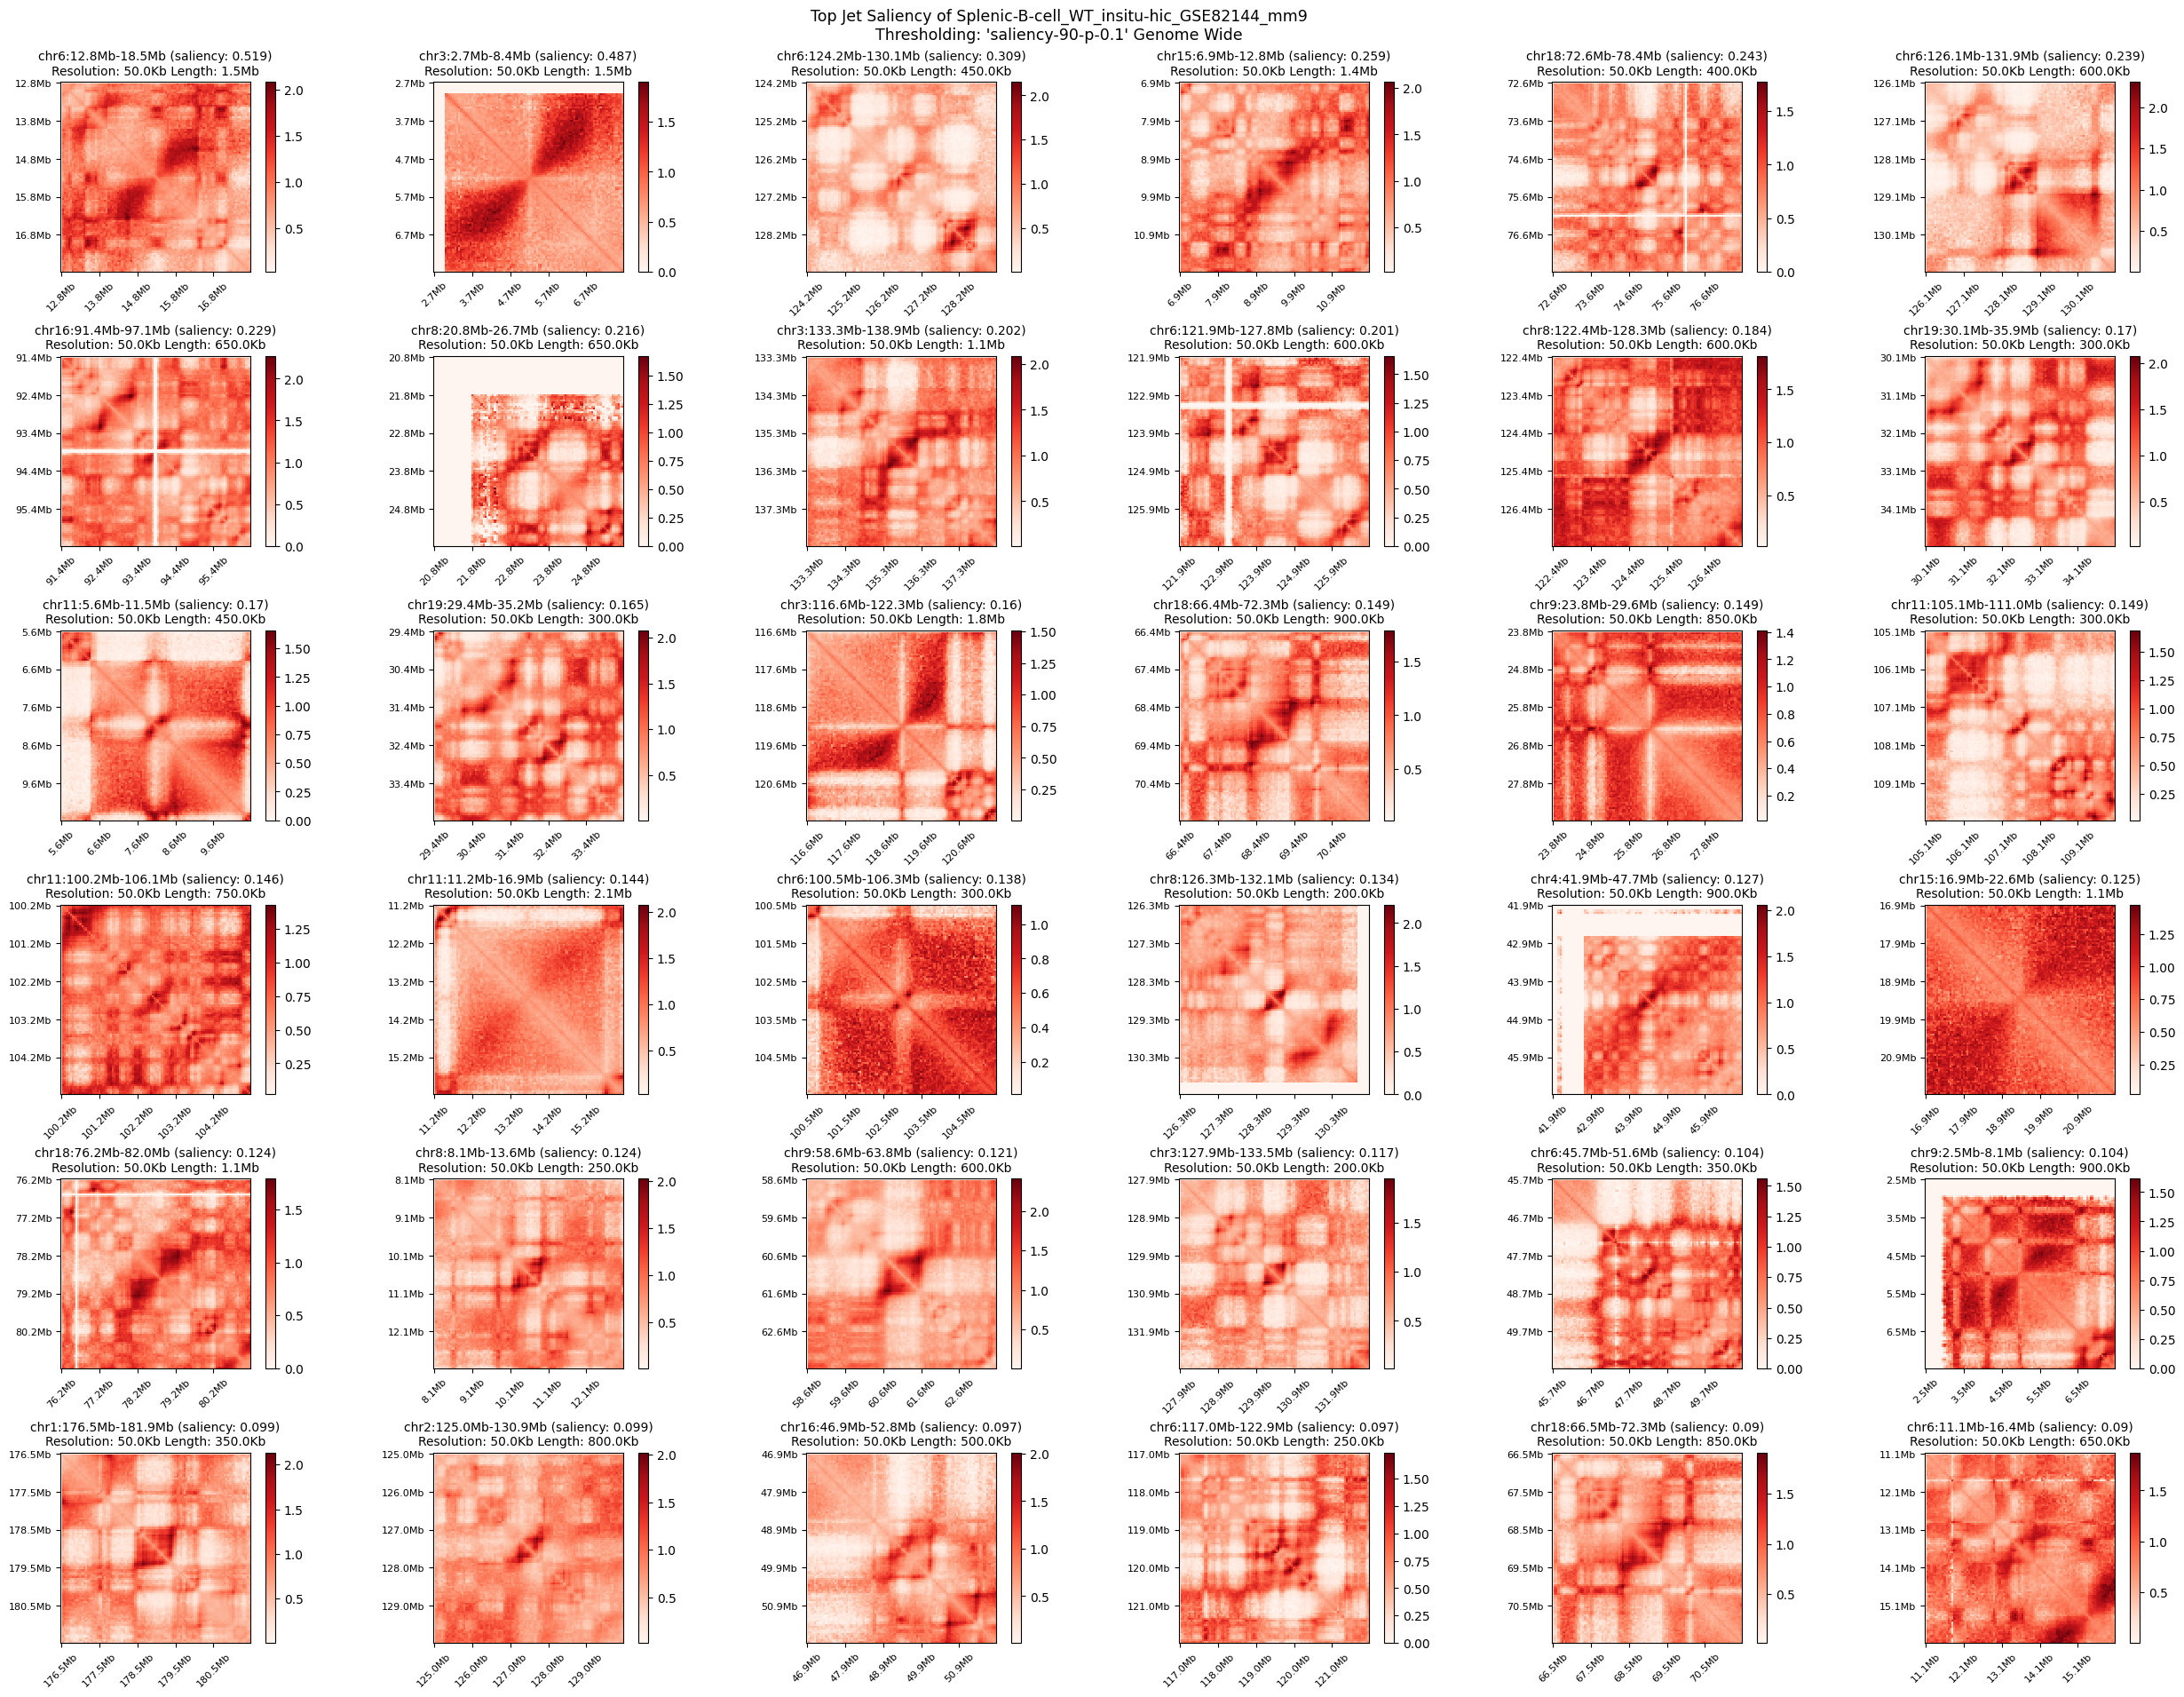

In [ ]:
plot_n_hic(sampled_stack, 
           titles=titles, 
           resolution=resolutions,
           suptitle="Top Jet Saliency of Splenic-B-cell_WT_insitu-hic_GSE82144_mm9\nThresholding: 'saliency-90-p-0.1' Genome Wide", 
           show=True, 
           genomic_shift=genomic_shift, 
           cmap_label=None, 
           ppr=6,
           cmap="Reds")